In [1]:
import awkward as ak
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

## CMS style

In [2]:
import mplhep as hep

hep.style.use("CMS")
palette = ["#5790fc", "#f89c20", "#e42536", "#964a8b", "#9c9ca1", "#7a21dd"]

The nice thing of having `.parquet` trees as output is that they are really easy to manipulate with python using `awkward` and `numpy`.

First we load the MC and data samples, this is achieved using awkward, which unpack the `.parquet` HiggsDNA NTuple in a jagged array.

If you used the linked files you should change the location

In [9]:
# Load the data
data_arr = ak.from_parquet('02_NTuples/DataC_2022/')
print(data_arr.tag_seediEtaOriX)

# Load MC samples
MC_dict = {}
processes = ['DY']
for process in processes:
    MC_dict[f'{process}_arr'] = ak.from_parquet(f'02_NTuples/{process}/')

[-47, -65, 42, 68, 28, 28, 28, 37, 11, ... 26, -23, -57, 11, 58, 26, -36, -36, -30]


The field can be accessed as a dictionary, i.e. `array["mass"]`, or as a subfield `array.mass`. If we have a nested field this can be reached just adding a layer, as `array["field"]["subfield"]` or `array.field.subfield`.

The complete set of fields available in our input array can be seen by using the `.field` command of the `ak.Array` object

In [4]:
MC_dict['DY_arr'].fields

['tag_seediEtaOriX',
 'tag_cutBased',
 'tag_electronVeto',
 'tag_hasConversionTracks',
 'tag_isScEtaEB',
 'tag_isScEtaEE',
 'tag_mvaID_WP80',
 'tag_mvaID_WP90',
 'tag_pixelSeed',
 'tag_seedGain',
 'tag_electronIdx',
 'tag_jetIdx',
 'tag_seediPhiOriY',
 'tag_vidNestedWPBitmap',
 'tag_ecalPFClusterIso',
 'tag_energyErr',
 'tag_energyRaw',
 'tag_esEffSigmaRR',
 'tag_esEnergyOverRawE',
 'tag_eta',
 'tag_etaWidth',
 'tag_haloTaggerMVAVal',
 'tag_hcalPFClusterIso',
 'tag_hoe',
 'tag_hoe_PUcorr',
 'tag_mvaID',
 'tag_pfChargedIso',
 'tag_pfChargedIsoPFPV',
 'tag_pfChargedIsoWorstVtx',
 'tag_pfPhoIso03',
 'tag_pfRelIso03_all_quadratic',
 'tag_pfRelIso03_chg_quadratic',
 'tag_phi',
 'tag_phiWidth',
 'tag_pt',
 'tag_r9',
 'tag_s4',
 'tag_sieie',
 'tag_sieip',
 'tag_sipip',
 'tag_superclusterEta',
 'tag_trkSumPtHollowConeDR03',
 'tag_trkSumPtSolidConeDR04',
 'tag_x_calo',
 'tag_y_calo',
 'tag_z_calo',
 'tag_genPartFlav',
 'tag_genPartIdx',
 'tag_electronIdxG',
 'tag_genPartIdxG',
 'tag_jetIdxG',
 

# Plotting distributions
We now define the directory for plots, and configure the histogram binning

In [5]:
# directory for output plots
plots_dir = './plots'
Path(plots_dir).mkdir(exist_ok=True)

# Define the binning
n_bins = 60
x_low = 60
x_high = 120
binning = np.linspace(x_low, x_high, n_bins + 1)
width = binning[1] - binning[0]
center = (binning[:-1] + binning[1:]) / 2

## Mass plot

We then create a mass histograms starting from our data and MC arrays

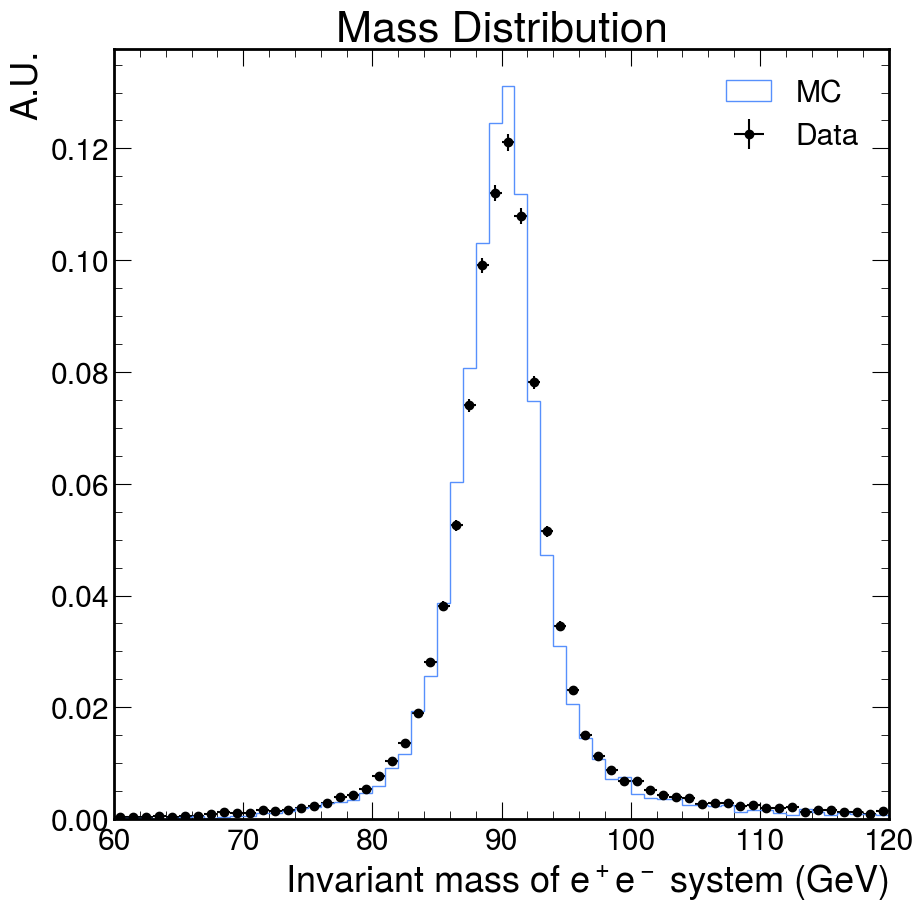

In [6]:
# Compute the data histogram, ignoring NaN values, and normalise
print(data_arr)
mask_data = (data_arr.mass > 60) & (data_arr.mass < 120)
mask_MC = (MC_dict['DY_arr'].mass > 60) & (MC_dict['DY_arr'].mass < 120)

mass_data_hist = np.histogram(data_arr.mass[mask_data], bins=binning)[0]

xerrs = [width * 0.5 for _ in range(n_bins)]
yerrs = np.sqrt(mass_data_hist)

mass_data_hist = mass_data_hist / len(data_arr.mass[mask_data])
yerrs = yerrs / len(data_arr.mass[mask_data])

# normalise weights for the MC processes
norm_weights = {
    'DY': 1.0 / ak.sum(MC_dict['DY_arr'].weight[mask_MC])
}

mc_mass = MC_dict['DY_arr'].mass[mask_MC]
mc_weights = MC_dict['DY_arr'].weight[mask_MC] * norm_weights["DY"]

# Compute the weighted MC histogram, ignoring NaN values
mc_mass_hist = np.histogram(mc_mass, bins=binning, weights=mc_weights)[0]

# Plotting
plt.errorbar(center, mass_data_hist, xerr=xerrs, yerr=yerrs, linestyle="None", color="black", marker="o", label="Data")
plt.hist(center, bins=binning, weights=mc_mass_hist, histtype='step', label='MC')

plt.xlabel('Invariant mass of $e^+e^-$ system (GeV)')
plt.ylabel('A.U.')
plt.legend()
plt.xlim(x_low, x_high)
plt.ylim(bottom=0)
plt.title('Mass Distribution')
plt.savefig(f'{plots_dir}/zee_mass.png')
plt.show()

We can go one step further and try to add a ratio plot to check the Data/MC agreement

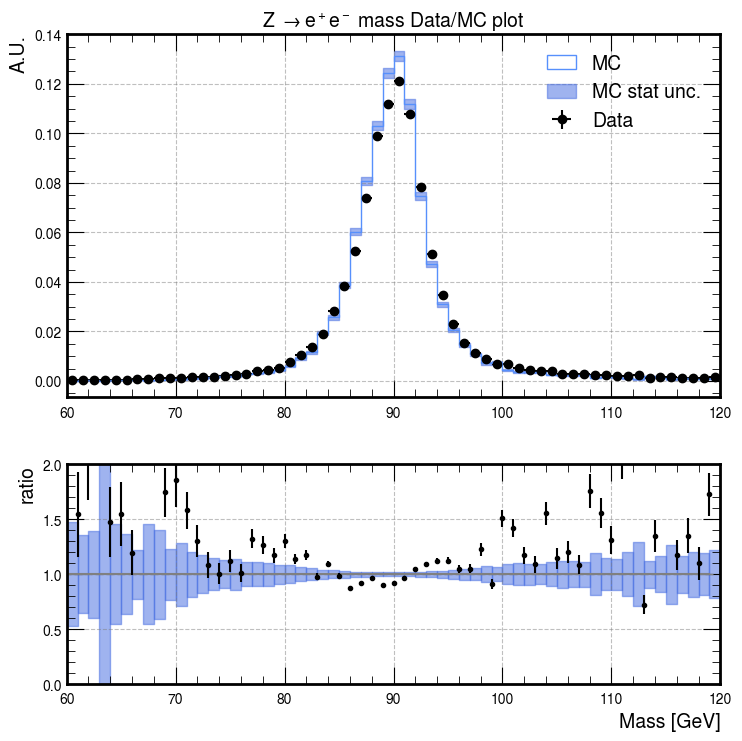

In [7]:
fig = plt.figure(figsize=(8, 8))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=3, colspan=3)

mass_data_hist = np.histogram(data_arr.mass[mask_data], bins=binning)[0]

xerrs = [width * 0.5 for _ in range(n_bins)]
yerrs = np.sqrt(mass_data_hist)

mass_data_hist = mass_data_hist / len(data_arr.mass[mask_data])
yerrs = yerrs / len(data_arr.mass[mask_data])

# normalise weights for the MC processes
norm_weights = {
    'DY': 1.0 / ak.sum(MC_dict['DY_arr'].weight[mask_MC])
}

mc_mass = MC_dict['DY_arr'].mass[mask_MC]
mc_weights = MC_dict['DY_arr'].weight[mask_MC] * norm_weights["DY"]
mc_square_weights = (MC_dict['DY_arr'].weight[mask_MC] ** 2)

# Compute the weighted MC histogram, ignoring NaN values
mc_mass_hist, mc_mass_bins = np.histogram(mc_mass, bins=binning, weights=mc_weights)
mc_mass_hist_err = np.histogram(mc_mass, bins=binning, weights=mc_square_weights)[0]

# Plotting
ax0.errorbar(center, mass_data_hist, xerr=xerrs, yerr=yerrs, linestyle="None", color="black", marker="o", label="Data")
ax0.hist(center, bins=binning, weights=mc_mass_hist, histtype='step', label='MC')

ydn = {}
yup = {}
# create up and down edges to plot shaded area for each bin
ydn["DY"] = [mc_mass_hist[i] - x for i, x in enumerate(np.sqrt(mc_mass_hist_err) * norm_weights["DY"])]
yup["DY"] = [mc_mass_hist[i] + x for i, x in enumerate(np.sqrt(mc_mass_hist_err) * norm_weights["DY"])]

# plot shaded area for MC errors
for i, x in enumerate(center):
    if i == 0:
        ax0.fill_between([x - width / 2., x + width / 2.], [ydn["DY"][i], ydn["DY"][i]], [yup["DY"][i], yup["DY"][i]], facecolor="royalblue", alpha=0.5, edgecolor="royalblue", label=f"MC stat unc.") # we want just one entry in the legend
    else:
        ax0.fill_between([x - width / 2., x + width / 2.], [ydn["DY"][i], ydn["DY"][i]], [yup["DY"][i], yup["DY"][i]], facecolor="royalblue", alpha=0.5, edgecolor="royalblue", label="")

# ratio plot
ax1 = plt.subplot2grid((5, 3), (3, 0), rowspan=2, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc_mass_hist != 0,
    mass_data_hist / mc_mass_hist,
    ak.ones_like(mc_mass_hist)
)
ax1.plot(mc_mass_bins[:-1], ak.ones_like(mc_mass_hist), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc_mass_bins[:-1], ratio, yerr = abs(yerrs/mc_mass_hist), color="black", marker=".", linestyle="", label="MC")

for i, x in enumerate(center):
    ax1.fill_between([x - width / 2., x + width / 2.], [ydn["DY"][i]/mc_mass_hist[i], ydn["DY"][i]/mc_mass_hist[i]], [yup["DY"][i]/mc_mass_hist[i], yup["DY"][i]/mc_mass_hist[i]], facecolor="royalblue", alpha=0.5, edgecolor="royalblue", label="MC stat unc.")


# cosmetics
ax0.set_ylabel('A.U.', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(r'$Z\;\rightarrow e^+e^-$ mass Data/MC plot', fontsize=14)
ax1.set_xlabel('Mass [GeV]', fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)

ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)
ax1.tick_params(axis='x', labelsize=10)
ax1.tick_params(axis='y', labelsize=10)

ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

ax1.set_ylim([0.,2])
ax1.set_xlim([x_low, x_high])
ax0.set_xlim([x_low, x_high])

plt.tight_layout()

plt.plot()
plt.savefig(f'{plots_dir}/zee_mass_data_mc_ratio.png')
plt.show()

It is clear that the agreement between data and mc is "suboptimal", you will explore in the next section of the tutorial the impact of correction on data/mc agreement.

# Hands on!

Now try yourself to produce plots for:
* `probe_pt`, Probe variable are the one under study in the Tag & Probe workflow. Here we plot the $p_T$ as an example (Suggested ranges for the x axis: 20, 150).
* `probe_r9`. Isolation variable (Suggested ranges for the x axis: 0, 1.5).

# probe $p_T$ plot

In [8]:
# Define the binning
n_bins = 65
x_low = 20
x_high = 150
binning = np.linspace(x_low, x_high, n_bins + 1)
width = binning[1] - binning[0]
center = (binning[:-1] + binning[1:]) / 2

/tmp/chenhua/ipykernel_3488729/2126904216.py:50: RuntimeWarning: invalid value encountered in divide
  data_hist / mc_hist,
/tmp/chenhua/ipykernel_3488729/2126904216.py:55: RuntimeWarning: invalid value encountered in divide
  yerrs / mc_hist,
/tmp/chenhua/ipykernel_3488729/2126904216.py:62: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - width / 2., x + width / 2.], [ydn["DY"][i]/mc_hist[i], ydn["DY"][i]/mc_hist[i]], [yup["DY"][i]/mc_hist[i], yup["DY"][i]/mc_hist[i]], facecolor="royalblue", alpha=0.5, edgecolor="royalblue", label="MC stat unc.")


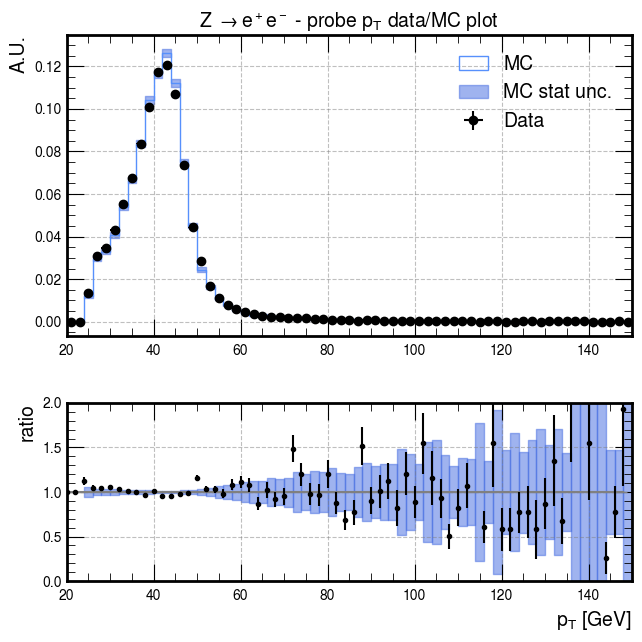

In [9]:
# lead photon eta
var = "probe_pt"
fig = plt.figure(figsize=(7, 7))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=3, colspan=3)

# Compute the data histogram, ignoring NaN values, and normalise
data_hist = np.histogram(data_arr[var][mask_data], bins=binning)[0]

xerrs = [width * 0.5 for _ in range(n_bins)]
yerrs = np.sqrt(data_hist)

data_hist = data_hist / len(data_arr[var][mask_data])
yerrs = yerrs / len(data_arr[var][mask_data])

# normalise weights for the MC processes
norm_weights = {
    'DY': 1.0 / ak.sum(MC_dict['DY_arr'].weight[mask_MC])
}

mc_weights = MC_dict['DY_arr'].weight[mask_MC] * norm_weights["DY"]
mc_square_weights = (MC_dict['DY_arr'].weight[mask_MC] ** 2)

# Compute the weighted MC histogram, ignoring NaN values
mc_hist, mc_bins = np.histogram(MC_dict['DY_arr'][var][mask_MC], bins=binning, weights=mc_weights)
mc_hist_err = np.histogram(MC_dict['DY_arr'][var][mask_MC], bins=binning, weights=mc_square_weights)[0]

# Plotting
ax0.errorbar(center, data_hist, xerr=xerrs, yerr=yerrs, linestyle="None", color="black", marker="o", label="Data")
ax0.hist(center, bins=binning, weights=mc_hist, histtype='step', label='MC')

ydn = {}
yup = {}
# create up and down edges to plot shaded area for each bin
ydn["DY"] = [mc_hist[i] - x for i, x in enumerate(np.sqrt(mc_hist_err) * norm_weights["DY"])]
yup["DY"] = [mc_hist[i] + x for i, x in enumerate(np.sqrt(mc_hist_err) * norm_weights["DY"])]

# plot shaded area for MC errors
for i, x in enumerate(center):
    if i == 0:
        ax0.fill_between([x - width / 2., x + width / 2.], [ydn["DY"][i], ydn["DY"][i]], [yup["DY"][i], yup["DY"][i]], facecolor="royalblue", alpha=0.5, edgecolor="royalblue", label=f"MC stat unc.") # we want just one entry in the legend
    else:
        ax0.fill_between([x - width / 2., x + width / 2.], [ydn["DY"][i], ydn["DY"][i]], [yup["DY"][i], yup["DY"][i]], facecolor="royalblue", alpha=0.5, edgecolor="royalblue", label="")

# ratio plot
ax1 = plt.subplot2grid((5, 3), (3, 0), rowspan=2, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc_hist != 0.,
    data_hist / mc_hist,
    ak.ones_like(mc_hist)
)
err_ratio = ak.where(
    mc_hist != 0.,
    yerrs / mc_hist,
    ak.zeros_like(mc_hist)
)
ax1.plot(mc_bins[:-1], ak.ones_like(mc_hist), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc_bins[:-1], ratio, yerr = abs(err_ratio), color="black", marker=".", linestyle="", label="MC")

for i, x in enumerate(center):
    ax1.fill_between([x - width / 2., x + width / 2.], [ydn["DY"][i]/mc_hist[i], ydn["DY"][i]/mc_hist[i]], [yup["DY"][i]/mc_hist[i], yup["DY"][i]/mc_hist[i]], facecolor="royalblue", alpha=0.5, edgecolor="royalblue", label="MC stat unc.")


# cosmetics
ax0.set_ylabel('A.U.', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(r'$Z\;\rightarrow e^+e^-$ - probe $p_T$ data/MC plot', fontsize=14)
ax1.set_xlabel('$p_T$ [GeV]', fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)

ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)
ax1.tick_params(axis='x', labelsize=10)
ax1.tick_params(axis='y', labelsize=10)

ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

ax1.set_ylim([0.,2])
ax1.set_xlim([x_low, x_high])
ax0.set_xlim([x_low, x_high])

plt.tight_layout()

plt.plot()
plt.show()

# Probe electron $r_9$

In [10]:
# Define the binning
n_bins = 30
x_low = 0
x_high = 1.5
binning = np.linspace(x_low, x_high, n_bins + 1)
width = binning[1] - binning[0]
center = (binning[:-1] + binning[1:]) / 2

/tmp/chenhua/ipykernel_3488729/2436014192.py:50: RuntimeWarning: divide by zero encountered in divide
  data_hist / mc_hist,
/tmp/chenhua/ipykernel_3488729/2436014192.py:50: RuntimeWarning: invalid value encountered in divide
  data_hist / mc_hist,
/tmp/chenhua/ipykernel_3488729/2436014192.py:55: RuntimeWarning: divide by zero encountered in divide
  yerrs / mc_hist,
/tmp/chenhua/ipykernel_3488729/2436014192.py:55: RuntimeWarning: invalid value encountered in divide
  yerrs / mc_hist,
/tmp/chenhua/ipykernel_3488729/2436014192.py:62: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - width / 2., x + width / 2.], [ydn["DY"][i]/mc_hist[i], ydn["DY"][i]/mc_hist[i]], [yup["DY"][i]/mc_hist[i], yup["DY"][i]/mc_hist[i]], facecolor="royalblue", alpha=0.5, edgecolor="royalblue", label="MC stat unc.")


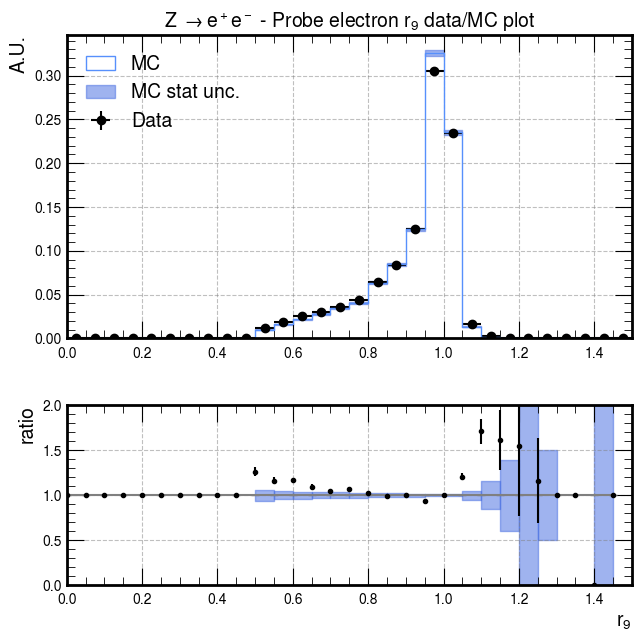

In [11]:
# lead photon eta
var = "probe_r9"
fig = plt.figure(figsize=(7, 7))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=3, colspan=3)

# Compute the data histogram, ignoring NaN values, and normalise
data_hist = np.histogram(data_arr[var][mask_data], bins=binning)[0]

xerrs = [width * 0.5 for _ in range(n_bins)]
yerrs = np.sqrt(data_hist)

data_hist = data_hist / len(data_arr[var][mask_data])
yerrs = yerrs / len(data_arr[var][mask_data])

# normalise weights for the MC processes
norm_weights = {
    'DY': 1.0 / ak.sum(MC_dict['DY_arr'].weight[mask_MC])
}

mc_weights = MC_dict['DY_arr'].weight[mask_MC] * norm_weights["DY"]
mc_square_weights = (MC_dict['DY_arr'].weight[mask_MC] ** 2)

# Compute the weighted MC histogram, ignoring NaN values
mc_hist, mc_bins = np.histogram(MC_dict['DY_arr'][var][mask_MC], bins=binning, weights=mc_weights)
mc_hist_err = np.histogram(MC_dict['DY_arr'][var][mask_MC], bins=binning, weights=mc_square_weights)[0]

# Plotting
ax0.errorbar(center, data_hist, xerr=xerrs, yerr=yerrs, linestyle="None", color="black", marker="o", label="Data")
ax0.hist(center, bins=binning, weights=mc_hist, histtype='step', label='MC')

ydn = {}
yup = {}
# create up and down edges to plot shaded area for each bin
ydn["DY"] = [mc_hist[i] - x for i, x in enumerate(np.sqrt(mc_hist_err) * norm_weights["DY"])]
yup["DY"] = [mc_hist[i] + x for i, x in enumerate(np.sqrt(mc_hist_err) * norm_weights["DY"])]

# plot shaded area for MC errors
for i, x in enumerate(center):
    if i == 0:
        ax0.fill_between([x - width / 2., x + width / 2.], [ydn["DY"][i], ydn["DY"][i]], [yup["DY"][i], yup["DY"][i]], facecolor="royalblue", alpha=0.5, edgecolor="royalblue", label=f"MC stat unc.") # we want just one entry in the legend
    else:
        ax0.fill_between([x - width / 2., x + width / 2.], [ydn["DY"][i], ydn["DY"][i]], [yup["DY"][i], yup["DY"][i]], facecolor="royalblue", alpha=0.5, edgecolor="royalblue", label="")

# ratio plot
ax1 = plt.subplot2grid((5, 3), (3, 0), rowspan=2, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc_hist != 0.,
    data_hist / mc_hist,
    ak.ones_like(mc_hist)
)
err_ratio = ak.where(
    mc_hist != 0.,
    yerrs / mc_hist,
    ak.zeros_like(mc_hist)
)
ax1.plot(mc_bins[:-1], ak.ones_like(mc_hist), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc_bins[:-1], ratio, yerr = abs(err_ratio), color="black", marker=".", linestyle="", label="MC")

for i, x in enumerate(center):
    ax1.fill_between([x - width / 2., x + width / 2.], [ydn["DY"][i]/mc_hist[i], ydn["DY"][i]/mc_hist[i]], [yup["DY"][i]/mc_hist[i], yup["DY"][i]/mc_hist[i]], facecolor="royalblue", alpha=0.5, edgecolor="royalblue", label="MC stat unc.")


# cosmetics
ax0.set_ylabel('A.U.', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(r'$Z\;\rightarrow e^+e^-$ - Probe electron $r_9$ data/MC plot', fontsize=14)
ax1.set_xlabel('$r_9$', fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)

ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)
ax1.tick_params(axis='x', labelsize=10)
ax1.tick_params(axis='y', labelsize=10)

ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

ax1.set_ylim([0.,2])
ax1.set_xlim([x_low, x_high])
ax0.set_xlim([x_low, x_high])

plt.tight_layout()

plt.plot()
plt.show()